In [1]:
# importing moudles
# and using some magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./Probs')

from aspen import aspen
from newton import newton

import partion as pt
import wrapper as wp

from one_phase import one_phase
from fix_bd_1D import fxbd_1D
import numpy as np
import matplotlib.pyplot as plt

test = wp.test_decorator(wp.test)
plt.style.use('default')

### Задаем нелинейную модель

In [2]:
# model to be studied
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

In [3]:
class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

### Вычислим константы
Используем четырехточечный шаблон - якобиан трехдиагональная матрица. Следовательно все линейно
$$
t_{res} = C_f \cdot N \\
t_{jac} = C_j \cdot N \\
t_{lin} = C_l \cdot N
$$
Примечание: вообще говоря это не константы и от задачи к задаче они будут меняться, но нам просто нужно получть представление о соотношениии порядков

In [6]:
Nt = 10

# obtain random coeficents
coefs = np.random.rand(7)

t_res = np.zeros((10, 4))
t_jac = np.zeros((10, 4))
t_lin = np.zeros((10, 4))

for i in range(0, 10):
    Nx = 2000 +i*200
    param ={'Nx': Nx, 'Nt' : Nt}
    # set initial condition
    x0 = np.ones(Nx)
    x = np.linspace(0, 1, Nx)
    for k in range(len(coefs)):
        x0 += (1-coefs[k])*np.sin(np.pi*k*x)
    x0 = x0.reshape(-1, 1)
    D = Diffusion(Nx, 0.9, 1, 2e-2, model=model)
    bd1 = x0[0]
    bd2 = x0[-1]
    
    prob = one_phase(D, param)
    solver_n = fxbd_1D(param, prob)
    solver_n.setBoundary(bd1, bd2)
    nl_solver = newton(crit_abs=1e-6)
    solver_n.setSolver(nl_solver)
    solver_n.setInitial(x0)
    
    for j in range(4):
        solver_n.init_log()
        _, mes = solver_n.solve(tmax=0.1)
        sum_k = np.sum(solver_n.timelog.kn)
        t_res[i, j] = solver_n.timelog.res/((sum_k+1)*10)
        t_jac[i, j] = solver_n.timelog.jac/((sum_k)*10)
        t_lin[i, j] = solver_n.timelog.lin/((sum_k)*10)
        
    print(Nx, np.mean(t_res[i, :]), np.mean(t_jac[i, :]), np.mean(t_lin[i, :]), mes)

2000 0.009560626268386841 0.006910428404808044 0.0036388881504535674 OK
2200 0.009835448503494264 0.007542167603969574 0.0041825788716475165 OK
2400 0.010535893201828003 0.008243600775798162 0.00488834356268247 OK
2600 0.011413808345794679 0.009092011302709578 0.005714084456364314 OK
2800 0.012700741052627564 0.010390622417132058 0.006809235612551372 OK
3000 0.012932712554931641 0.010836289823055267 0.007507122059663136 OK
3200 0.013769518375396727 0.011710361142953239 0.00852604682246844 OK
3400 0.014611898183822632 0.012743611633777617 0.009527874986330669 OK
3600 0.015637031555175783 0.013887979835271836 0.010622894763946534 OK
3800 0.016228280305862427 0.014770652602116265 0.011603444814682007 OK


[3.62172241e-06] [[8.66487154e-08]]
[4.20328463e-06] [[7.54424944e-08]]
[4.19981882e-06] [[9.22885034e-08]]


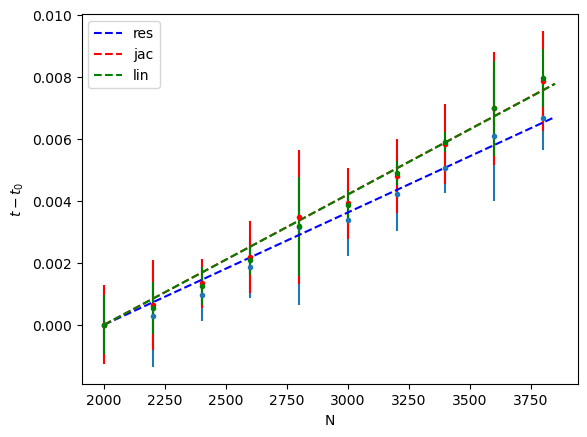

In [7]:
Nx = np.arange(2000, 2000+9*200+1, 200)

from scipy.optimize import curve_fit
def func(x, a):
    return x*a

plt.ylabel('$t-t_0$')
plt.xlabel('N')
plt.errorbar(Nx, np.mean(t_res, axis=1)-np.mean(t_res, axis=1)[0],yerr= np.sqrt(np.std(t_res, axis=1))/10, marker='.', linestyle='')
plt.errorbar(Nx, np.mean(t_jac, axis=1)-np.mean(t_jac, axis=1)[0],yerr= np.sqrt(np.std(t_jac, axis=1))/10,marker='.', linestyle='', color='r')
plt.errorbar(Nx, np.mean(t_lin, axis=1)-np.mean(t_lin, axis=1)[0],yerr= np.sqrt(np.std(t_lin, axis=1))/10,marker='.',linestyle='', color='g')

popt, pcov = curve_fit(func, Nx-2000, np.mean(t_res, axis=1)-np.mean(t_res, axis=1)[0])
print(popt, np.sqrt(pcov))
c_r = popt[0]
plt.plot([2000, 3850], [0, popt[0]*(2850-1000)], color='b', label='res', linestyle='--')
popt, pcov = curve_fit(func, Nx-2000, np.mean(t_jac, axis=1)-np.mean(t_jac, axis=1)[0])
print(popt, np.sqrt(pcov))
c_j = popt[0]
plt.plot([2000, 3850], [0, popt[0]*(2850-1000)], color='r', label='jac', linestyle='--')
popt, pcov = curve_fit(func, Nx-2000, np.mean(t_lin, axis=1)-np.mean(t_lin, axis=1)[0])
print(popt, np.sqrt(pcov))
plt.plot([2000, 3850], [0, popt[0]*(2850-1000)], color='g', label='lin', linestyle='--')
c_l = popt[0]

plt.legend()
plt.savefig('./data/constants.png', dpi=300)
plt.show()

### Зададим начальное условие, с которым будем работать
Пока возьмем какое-то одно и накинем сверху еще источник для усложнения

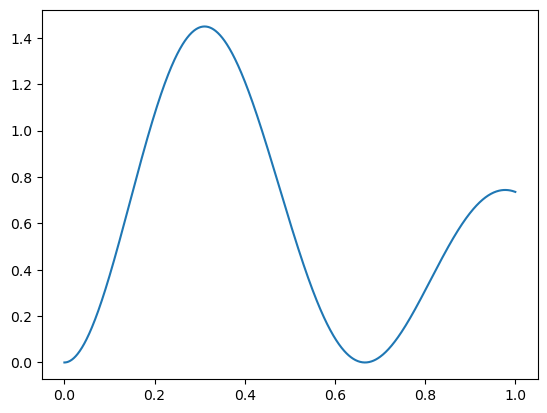

In [8]:
Nx = 1000
Nt = 10
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
D = Diffusion(Nx, 0.9, 1, 0.2e-2, model=model)
x0 = 2*np.exp(-x)*np.sin(3*np.pi/2*x)**2
x0 = x0.reshape(-1, 1)
bd1 = x0[0]
bd2 = x0[-1]

plt.plot(x, x0)
plt.show()

### Решим задачу использую солвер с методом Ньютона

In [9]:
prob = one_phase(D, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
solver_n.setSources([0.625], [-0.6])

In [10]:
nl_solver = newton(crit_abs=1e-8)
solver_n.setSolver(nl_solver)

In [11]:
solver_n.setInitial(x0)
X, mes, t, delta = test(solver_n, sample_size = 4)

test started


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


verdict : OK
time : 3.573 +- 0.4817
mean newton iterations:  4.3


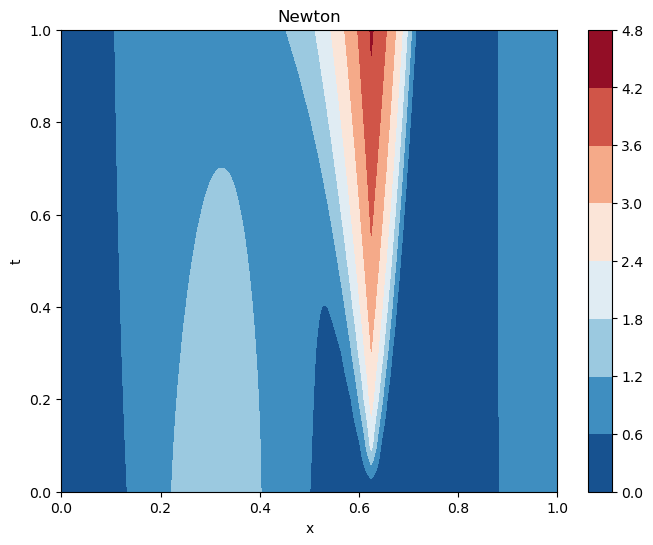

In [12]:
wp.show_res(solver_n)
plt.show()

In [13]:
cost_new = solver_n.timelog.kn*Nx*(c_r+c_j+c_l)+c_r*Nx

### Теперь используем стандартный ASPEN

In [14]:
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.625], [-0.6])
solver.setInitial(x0)

In [15]:
Nd = 4
partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs=1e-8)
solver.setSolver(nl_solver)

In [16]:
X, mes, t, delta = test(solver, sample_size=4)

test started
verdict : OK
time : 6.741 +- 0.7608
mean aspen iterations:  3.5


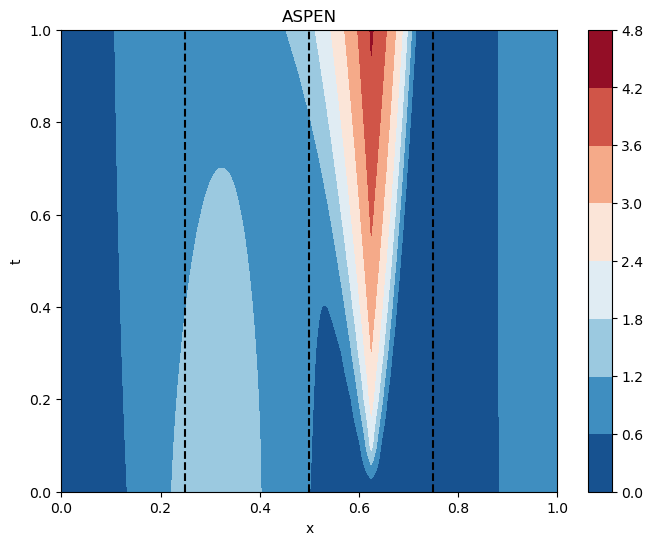

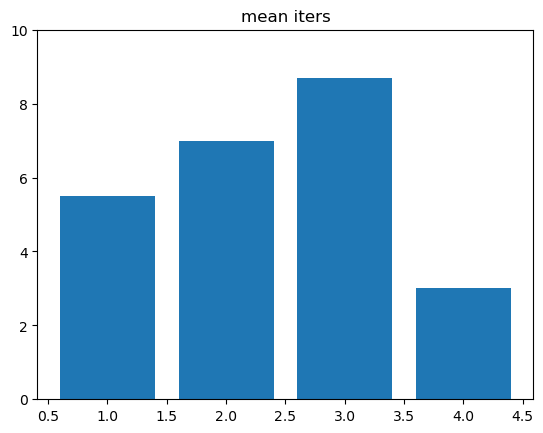

In [17]:
wp.show_res(solver, save='Diff0_ASPEN')
wp.bar_loc(solver, Nd, save='Diff0_mean_loc')

In [18]:
cost_eq = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))

--time comparision--
newton : 0.6445901393890381
aspen : 1.2537086009979248


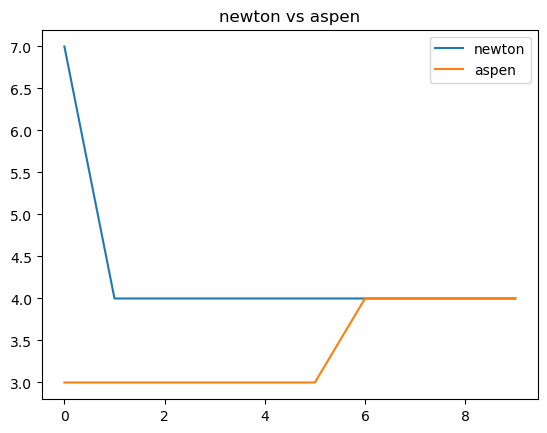

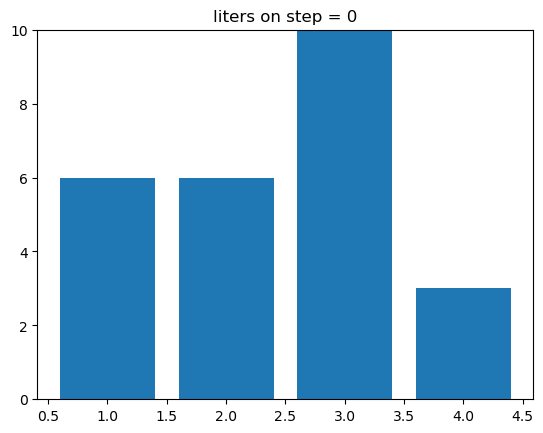

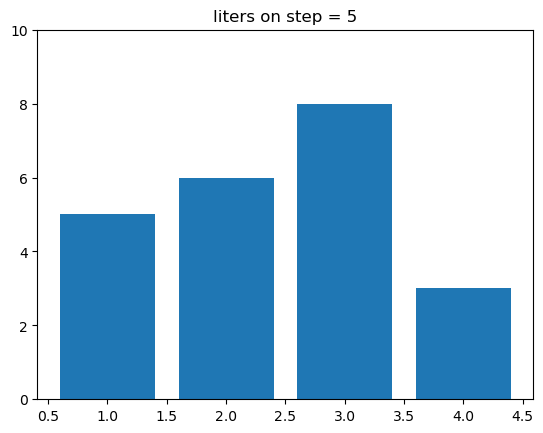

In [188]:
wp.compare([solver_n, solver], ['newton', 'aspen'])#, save='comp')
wp.bar_loc_step(solver, Nd, 0)#, save='step=0')
wp.bar_loc_step(solver, Nd, 5)#, save='step=5')

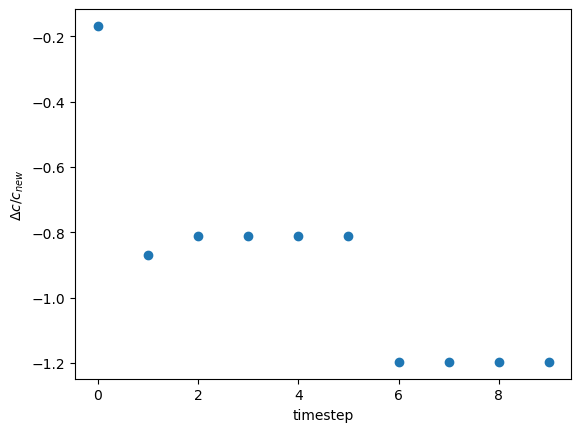

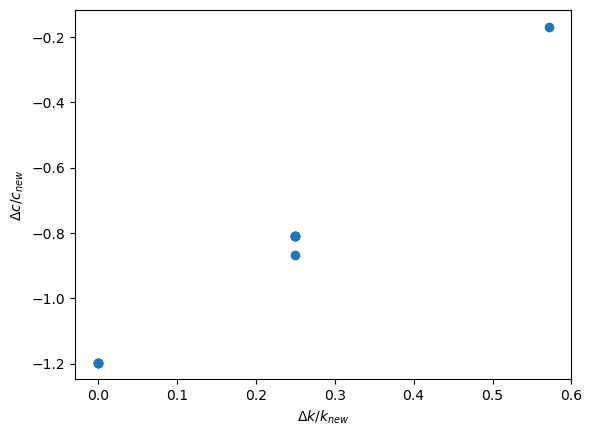

In [191]:
plt.scatter(np.arange(Nt), (cost_new-cost_eq)/cost_new)
plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.savefig('./data/const_over_time_eq', dpi = 300)
plt.show()

x = (solver_n.timelog.kn-solver.timelog.aspen_iters)/solver_n.timelog.kn
plt.scatter(x, (cost_new-cost_eq)/cost_new)
plt.xlabel('$\Delta k/k_{new}$')
plt.ylabel('$\Delta c/c_{new}$')
plt.savefig('./data/const_over_k_eq', dpi = 300)
plt.show()

### Иследуем зависимость скорости от погрешности локальной стадии
Тут идея такая: раз у нас получилось много иттераций в локальной стадии, то попробуем задать для неё более мягкий критерий. Нет необходимости считать локлаьные домены слишком точно - все равно на глобальной стадии возникнет поправка

In [23]:
Nd = 4
Nx = 1000
Nt = 10
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
param ={'Nx': Nx, 'Nt' : Nt}
D = Diffusion(Nx, 0.9, 1, 0.2e-2, model=model)

prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.625], [-0.6])
solver.setInitial(x0)

In [105]:
partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs = 1e-8)
solver.setSolver(nl_solver)

In [108]:
time = np.zeros(10)
delta = np.zeros(10)
gb_iters = np.zeros((10, Nt))
lc_iters = np.zeros((10, Nd, Nt))
Cost_softloc = np.zeros((10, Nt))

i = 0
for loc in np.logspace(-8, -6, 10):
    nl_solver = aspen(Nd, partion, crit_abs = 1e-8, crit_loc = loc)
    solver.setSolver(nl_solver)
    _, mes, time[i], delta[i] = test(solver, sample_size=4)
    gb_iters[i, :] = solver.timelog.aspen_iters
    lc_iters[i, :, :] = solver.timelog.domain_iters
    if(mes != 'OK'):
        print(i, mes)
    Cost_softloc[i, :] = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))
    i += 1

test started
verdict : OK
time : 6.487 +- 0.5075
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.863 +- 0.1679
mean aspen iterations:  3.5
test started
verdict : OK
time : 7.054 +- 0.2415
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.811 +- 0.3892
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.716 +- 0.2807
mean aspen iterations:  3.5
test started
verdict : OK
time : 7.075 +- 0.4219
mean aspen iterations:  3.5
test started
verdict : OK
time : 7.259 +- 0.5113
mean aspen iterations:  3.5
test started
verdict : Not converged
time : 3.071 +- 0.3469
mean aspen iterations:  1.5
7 Not converged
test started
verdict : Not converged
time : 2.95 +- 0.1397
mean aspen iterations:  1.5
8 Not converged
test started
verdict : Not converged
time : 2.935 +- 0.2459
mean aspen iterations:  1.5
9 Not converged


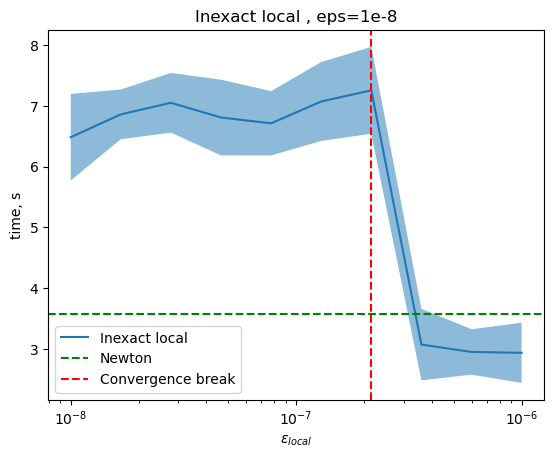

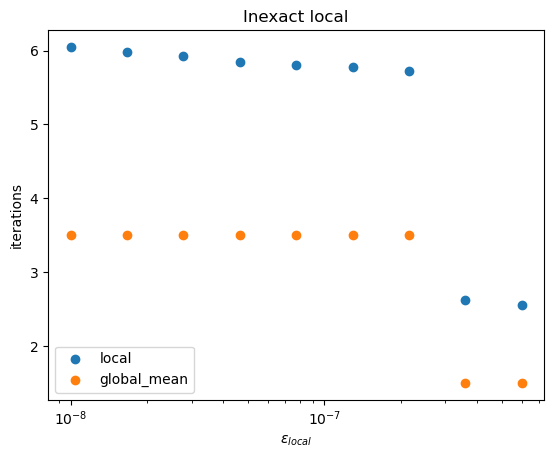

In [112]:
crit_rel = np.logspace(-8, -6, 10)

plt.title('Inexact local , eps=1e-8')
plt.ylabel('time, s')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.plot(crit_rel, time, label='Inexact local')
plt.fill_between(crit_rel, time+np.sqrt(delta),
                time-np.sqrt(delta), alpha=0.5)
plt.savefig('./data/Diff0_I_time', dpi=400)
plt.axhline(3.573, color='g', linestyle='--', label='Newton')
plt.axvline(np.logspace(-8, -6, 10)[6], color='r', linestyle='--', label='Convergence break')
plt.legend()
plt.show()

plt.title('Inexact local')
plt.ylabel('iterations')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.scatter(crit_rel[:-1], np.mean(np.mean(lc_iters, axis = 2), axis = 1)[:-1], label='local')
plt.scatter(crit_rel[:-1], np.mean(gb_iters, axis = 1)[:-1], label='global_mean')
plt.legend()
plt.savefig('./data/Diff0_I_lc_iters', dpi=400)
plt.show()

In [139]:
print(gb_iters, lc_iters, Cost_softloc)

[[3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 0. 0. 0. 0. 0.]
 [3. 3. 3. 3. 3. 0. 0. 0. 0. 0.]
 [3. 3. 3. 3. 3. 0. 0. 0. 0. 0.]] [[[ 6.  6.  6.  6.  6.  5.  5.  5.  5.  5.]
  [ 6.  6.  6.  6.  6.  8.  8.  8.  8.  8.]
  [10.  8.  7.  7.  7.  8. 10. 10. 10. 10.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 6.  6.  6.  5.  5.  5.  5.  5.  5.  5.]
  [ 6.  6.  6.  6.  6.  7.  8.  8.  8.  8.]
  [10.  8.  7.  7.  7.  8. 10. 10. 10. 10.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 6.  6.  5.  5.  5.  5.  5.  5.  5.  5.]
  [ 6.  6.  6.  6.  6.  7.  8.  8.  8.  8.]
  [10.  8.  7.  7.  7.  8.  9. 10. 10. 10.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 6.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
  [ 6.  6.  6.  6.  6.  7.  8.  8.  8.  8.]
  [10.  7.  7.  7.  7.  7.  9. 10. 10. 10.]
  [

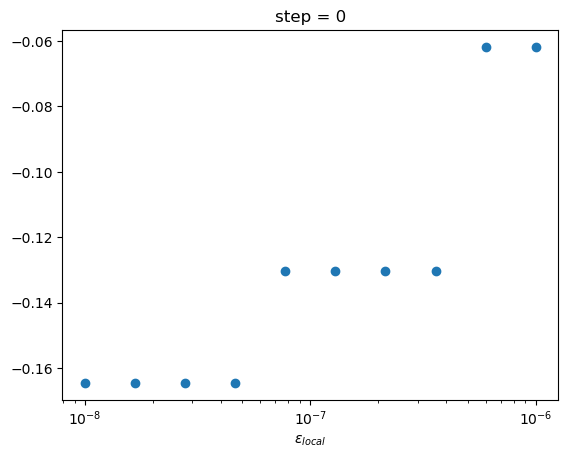

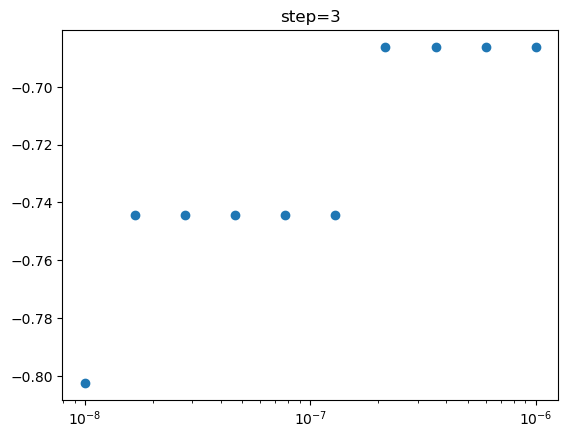

In [138]:
crit_rel = np.logspace(-8, -6, 10)
plt.title('step = 0')
plt.xscale('log')
plt.xlabel(r'$\varepsilon_{local}$')
plt.scatter(crit_rel, (cost_new[0]-Cost_softloc[:, 0])/cost_new[0])
plt.show()
plt.title('step=3')
plt.xscale('log')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xlabel('')
plt.scatter(crit_rel, (cost_new[3]-Cost_softloc[:, 3])/cost_new[3])
plt.show()

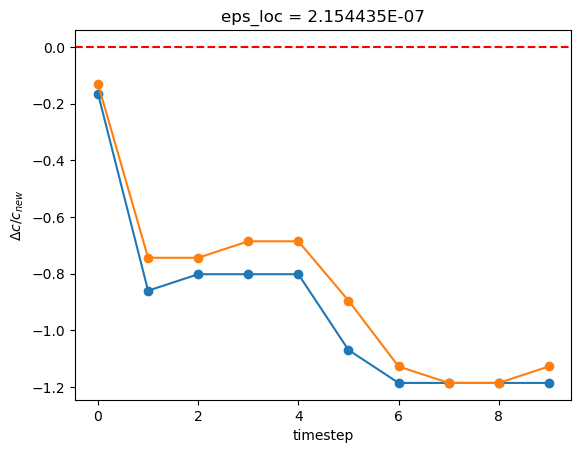

In [114]:
plt.plot(np.arange(Nt), (cost_new-cost_eq)/cost_new, marker='o')
plt.plot(np.arange(Nt), (cost_new-Cost_softloc[6, :])/cost_new, marker='o')
plt.title('eps_loc = {:4E}'.format(np.logspace(-8, -6, 10)[6]))
plt.axhline(0, linestyle='--', color='r')

plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.savefig('./data/const_comp_over_time_eq', dpi = 300)
plt.show()

### Введем относительную погрешность
Изначально, в ASPEN задается абсолютный критерий, но введем наряду с ним в локальной стадии относительную погршеность.

In [140]:
Nd = 4
Nx = 1000
Nt = 10
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
param ={'Nx': Nx, 'Nt' : Nt}
D = Diffusion(Nx, 0.9, 1, 0.2e-2, model=model)

prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.625], [-0.6])
solver.setInitial(x0)

partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs = 1e-8)
solver.setSolver(nl_solver)

In [142]:
time = np.zeros(20)
delta = np.zeros(20)
gb_iters = np.zeros((20, Nt))
lc_iters = np.zeros((20, Nd, Nt))
Cost_softloc = np.zeros((20, Nt))

i = 0
for crit_rel in np.logspace(-8, -1, 20):
    nl_solver = aspen(Nd, partion, crit_abs = 1e-8, crit_rel = crit_rel)
    solver.setSolver(nl_solver)
    _, mes, time[i], delta[i] = test(solver, sample_size=4)
    gb_iters[i, :] = solver.timelog.aspen_iters
    lc_iters[i, :, :] = solver.timelog.domain_iters
    if(mes != 'OK'):
        print(i, mes)
    Cost_softloc[i, :] = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))
    i += 1

test started
verdict : OK
time : 6.67 +- 0.4591
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.959 +- 0.5613
mean aspen iterations:  3.5
test started
verdict : OK
time : 7.022 +- 0.5589
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.652 +- 0.1721
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.698 +- 0.2429
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.709 +- 0.322
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.879 +- 0.5932
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.624 +- 0.259
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.338 +- 0.2081
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.305 +- 0.293
mean aspen iterations:  3.5
test started
verdict : OK
time : 6.11 +- 0.1577
mean aspen iterations:  3.5
test started
verdict : OK
time : 5.968 +- 0.1523
mean aspen iterations:  3.5
test started
verdict : OK
time : 5.836 +- 0.2202
mean aspen iterations:  3.5
test

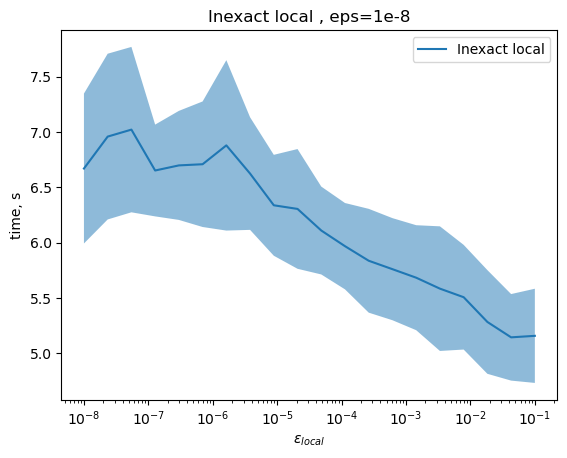

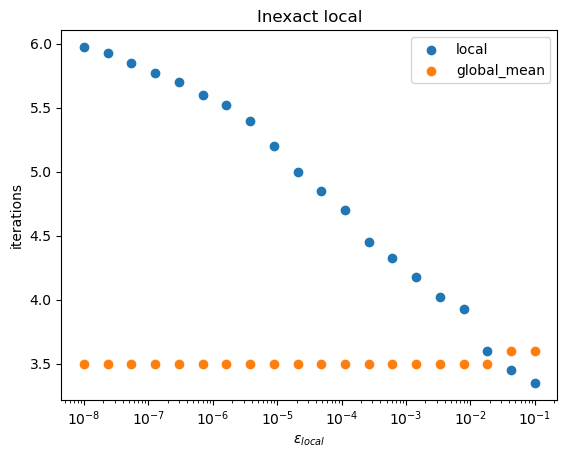

In [165]:
crit_rel = np.logspace(-8, -1, 20)

plt.title('Inexact local , eps=1e-8')
plt.ylabel('time, s')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.plot(crit_rel, time, label='Inexact local')
plt.fill_between(crit_rel, time+np.sqrt(delta),
                time-np.sqrt(delta), alpha=0.5)
plt.savefig('./data/rel0_Diff0_I_time', dpi=400)
plt.legend()
plt.show()

plt.title('Inexact local')
plt.ylabel('iterations')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.scatter(crit_rel, np.mean(np.mean(lc_iters, axis = 2), axis = 1), label='local')
plt.scatter(crit_rel, np.mean(gb_iters, axis = 1), label='global_mean')
plt.legend()
plt.savefig('./data/rel0_Diff0_I_lc_iters', dpi=400)
plt.show()

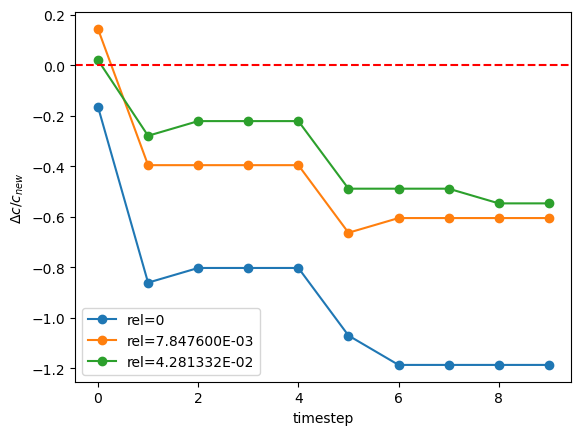

In [164]:
plt.plot(np.arange(Nt), (cost_new-cost_eq)/cost_new, marker='o', label='rel=0')
plt.plot(np.arange(Nt), (cost_new-Cost_softloc[16, :])/cost_new, marker='o',
         label='rel={:4E}'.format(np.logspace(-8, -1, 20)[16]))
plt.plot(np.arange(Nt), (cost_new-Cost_softloc[18, :])/cost_new, marker='o',
         label='rel={:4E}'.format(np.logspace(-8, -1, 20)[18]))
plt.axhline(0, linestyle='--', color='r')

plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.legend()
plt.savefig('./data/rel_comp_over_time_eq', dpi = 300)
plt.show()

In [163]:
print(gb_iters)

[[3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [4. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [4. 3. 3. 3. 3. 4. 4. 4. 4. 4.]]
